Box(-1.2000000476837158, 0.6000000238418579, (2,), float32)
Discrete(3)
0
Episode:     0, average reward: -2.0, current epsilon: 1.00


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


100
Episode:   100, average reward: -200.0, current epsilon: 0.92
200
Episode:   200, average reward: -200.0, current epsilon: 0.84
300
Episode:   300, average reward: -200.0, current epsilon: 0.76
400
Episode:   400, average reward: -200.0, current epsilon: 0.68
500
Episode:   500, average reward: -200.0, current epsilon: 0.60
600
Episode:   600, average reward: -200.0, current epsilon: 0.52
700
Episode:   700, average reward: -200.0, current epsilon: 0.44
800
Episode:   800, average reward: -199.8, current epsilon: 0.36
900
Episode:   900, average reward: -199.9, current epsilon: 0.28
1000
Episode:  1000, average reward: -199.7, current epsilon: 0.20
1100
Episode:  1100, average reward: -199.6, current epsilon: 0.12
1200
Episode:  1200, average reward: -199.0, current epsilon: 0.04
1300
Episode:  1300, average reward: -188.3, current epsilon: -0.00
1400
Episode:  1400, average reward: -198.5, current epsilon: -0.00
1500
Episode:  1500, average reward: -192.6, current epsilon: -0.00
1

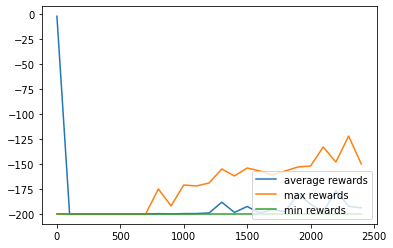

In [3]:
import gym
import numpy as np
import matplotlib.pyplot as plt
env = gym.make("MountainCar-v0")
env.reset()
print(env.observation_space)
print(env.action_space)

LEARNING_RATE = 0.1

DISCOUNT = 0.95
EPISODES = 2500
SHOW_EVERY = 100
STATS_EVERY=SHOW_EVERY
DISCRETE_OS_SIZE = [20, 20]
discrete_os_win_size = (env.observation_space.high - env.observation_space.low)/DISCRETE_OS_SIZE
ep_rewards=[]
aggr_ep_rewards={'ep':[] , 'avg':[] , 'min':[] , 'max':[]}

# Exploration settings
epsilon = 1  # not a constant, qoing to be decayed
START_EPSILON_DECAYING = 1
END_EPSILON_DECAYING = EPISODES//2
epsilon_decay_value = epsilon/(END_EPSILON_DECAYING - START_EPSILON_DECAYING)


q_table = np.random.uniform(low=-2, high=0, size=(DISCRETE_OS_SIZE + [env.action_space.n]))


def get_discrete_state(state):
    discrete_state = (state - env.observation_space.low)/discrete_os_win_size
    return tuple(discrete_state.astype(np.int))  # we use this tuple to look up the 3 Q values for the available actions in the q-table


for episode in range(EPISODES):
    episode_reward=0
    discrete_state = get_discrete_state(env.reset())
    done = False

    if episode % SHOW_EVERY == 0:
        render = True
        print(episode)
    else:
        render = False

    while not done:

        if np.random.random() > epsilon:
            # Get action from Q table
            action = np.argmax(q_table[discrete_state])
        else:
            # Get random action
            action = np.random.randint(0, env.action_space.n)


        new_state, reward, done, _ = env.step(action)

        episode_reward+=reward
        new_discrete_state = get_discrete_state(new_state)

        #new_q = (1 - LEARNING_RATE) * current_q + LEARNING_RATE * (reward + DISCOUNT * max_future_q)

        # If simulation did not end yet after last step - update Q table
        if not done:

            # Maximum possible Q value in next step (for new state) use of greedy policy to perform next action.
            max_future_q = np.max(q_table[new_discrete_state])

            # Current Q value (for current state and performed action)
            current_q = q_table[discrete_state + (action,)]

            # And here's our equation for a new Q value for current state and action
            new_q = (1 - LEARNING_RATE) * current_q + LEARNING_RATE * (reward + DISCOUNT * max_future_q)

            # Update Q table with new Q value
            q_table[discrete_state + (action,)] = new_q


        # Simulation ended (for any reson) - if goal position is achived - update Q value with reward directly
        elif new_state[0] >= env.goal_position:
            #q_table[discrete_state + (action,)] = reward
            q_table[discrete_state + (action,)] = 0

        discrete_state = new_discrete_state

    # Decaying is being done every episode if episode number is within decaying range
    if END_EPSILON_DECAYING >= episode >= START_EPSILON_DECAYING:
        epsilon -= epsilon_decay_value

    ep_rewards.append(episode_reward)
    if not episode % STATS_EVERY:
        average_reward = sum(ep_rewards[-STATS_EVERY:]) / STATS_EVERY
        aggr_ep_rewards['ep'].append(episode)
        aggr_ep_rewards['avg'].append(average_reward)
        aggr_ep_rewards['max'].append(max(ep_rewards[-STATS_EVERY:]))
        aggr_ep_rewards['min'].append(min(ep_rewards[-STATS_EVERY:]))

        print(f'Episode: {episode:>5d}, average reward: {average_reward:>4.1f}, current epsilon: {epsilon:>1.2f}')
plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['avg'], label="average rewards")
plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['max'], label="max rewards")
plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['min'], label="min rewards")
plt.legend(loc=4)
plt.show()
env.close()